In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
from pandas import read_csv
from datetime import datetime
from pandas import concat
import numpy as np
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = []
for i in range(15,29):
	dataset.append(read_csv('/content/drive/MyDrive/dataset/pollution_data' + '/fake_data_202208' + str(i) +'.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse))
dataset = concat([dataset[i] for i in range(len(dataset))], axis=0)
dataset.drop('No', axis=1, inplace=True) 
# manually specify column names
dataset.columns = ['local', 'temp', 'humidity', 'metter']
dataset.index.name = 'date'
# mark all NA values with 0
# dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
# dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5)) 
# save to file
dataset.to_csv('/content/drive/MyDrive/dataset/pollution_data/pollution.csv')
print(dataset)


                     local  temp  humidity  metter
date                                              
2022-08-15 09:00:00      1  23.5      38.3       3
2022-08-15 09:00:00      2  23.5      37.0       3
2022-08-15 09:00:00      3  23.2      35.0       3
2022-08-15 09:00:00      4  23.1      34.0       2
2022-08-15 09:00:00      5  23.3      33.5       1
                     local  temp  humidity  metter
date                                              
2022-08-15 09:00:00      1  23.5      38.3       3
2022-08-15 09:00:00      2  23.5      37.0       3
2022-08-15 09:00:00      3  23.2      35.0       3
2022-08-15 09:00:00      4  23.1      34.0       2
2022-08-15 09:00:00      5  23.3      33.5       1
...                    ...   ...       ...     ...
2022-08-28 21:00:00      2  17.3      54.0       2
2022-08-28 21:00:00      3  17.1      53.2       3
2022-08-28 21:00:00      4  17.1      54.1       0
2022-08-28 21:00:00      5  18.8      52.2       1
2022-08-28 21:00:00      6  18.

성능이 잘 안나와서 3D로 예측하려 함

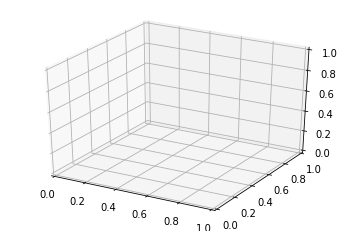

In [107]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

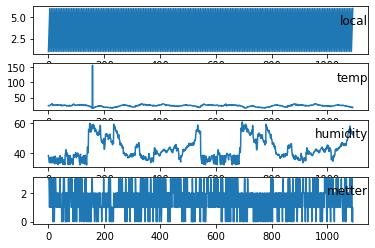

In [108]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('/content/drive/MyDrive/dataset/pollution_data/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [109]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	# print(df)
	cols, names = list(), list()
	# 7일 전의 환경 데이터를 input, 7일 후의 환경 데이터를 target으로 설정
	cols.append(df.shift(6*13*7))
	names += [('var%d(t-%d)' % (j+1, 7)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	cols.append(df)
	names += [('var%d(t)' % (j+1)) for j in range(n_vars)]

	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	# drop columns we don't want to predict
	agg.drop(agg.columns[[3,4]], axis=1, inplace=True)
	
	# 구역에 따라  환경데이터를 묶어준다.

	local = agg[['var1(t-7)',  'var2(t-7)',  'var3(t-7)']].values
	local = local.reshape(13*7,6,3)

	label = agg['var3(t)'].values.reshape(91,6)

	return local, label

# load dataset

dataset = read_csv('/content/drive/MyDrive/dataset/pollution_data/pollution.csv', header=0, index_col=0)
values = dataset.drop(['local'], axis = 1).values
# integer encode direction
encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed, target = series_to_supervised(scaled, 1, 1)
print(reframed.shape, target.shape)

(91, 6, 3) (91, 6)


In [110]:
# split into train and test sets
values = reframed
# 5일치를 학습시킴
n_train_hours = 78
train_X, train_y = values[:n_train_hours], target[:n_train_hours]
test_X,  test_y  = values[n_train_hours:], target[n_train_hours:]

# split into input and outputs

# reshape input to be 3D [samples, timesteps, features]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(78, 6, 3) (78, 6) (13, 6, 3) (13, 6)


Epoch 1/50
12/12 - 2s - loss: 0.4771 - accuracy: 0.1714 - val_loss: 0.4958 - val_accuracy: 0.0000e+00 - 2s/epoch - 136ms/step
Epoch 2/50
12/12 - 0s - loss: 0.4651 - accuracy: 0.1429 - val_loss: 0.4835 - val_accuracy: 0.0000e+00 - 71ms/epoch - 6ms/step
Epoch 3/50
12/12 - 0s - loss: 0.4517 - accuracy: 0.1429 - val_loss: 0.4681 - val_accuracy: 0.0000e+00 - 71ms/epoch - 6ms/step
Epoch 4/50
12/12 - 0s - loss: 0.4343 - accuracy: 0.1429 - val_loss: 0.4454 - val_accuracy: 0.0000e+00 - 71ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 0.4073 - accuracy: 0.1714 - val_loss: 0.4050 - val_accuracy: 0.0000e+00 - 93ms/epoch - 8ms/step
Epoch 6/50
12/12 - 0s - loss: 0.3565 - accuracy: 0.1714 - val_loss: 0.3182 - val_accuracy: 0.0000e+00 - 72ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 0.2827 - accuracy: 0.1714 - val_loss: 0.2247 - val_accuracy: 0.0000e+00 - 80ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 0.2557 - accuracy: 0.1714 - val_loss: 0.2174 - val_accuracy: 0.0000e+00 - 76ms/epoch - 6

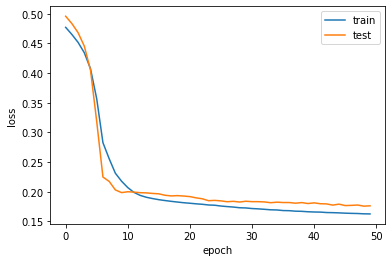

In [111]:

from keras.models import Sequential
from keras.layers import Dense, LSTM 
from keras.layers import BatchNormalization

# design network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2]), activation="softsign", recurrent_activation="elu"))
model.add(Dense(6))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=50 , batch_size=6, validation_data=(test_X, test_y), verbose=2, shuffle=False, validation_split = 0.1)
# plot historyz
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [112]:

# import math
# from sklearn.metrics import mean_squared_error
# # make a prediction
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0]*test_X.shape[1], test_X.shape[2]))
# yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
# print(test_X.shape, yhat.shape)

# # invert scaling for forecast
# inv_yhat = np.concatenate(( test_X[:,:-1],yhat), axis = 1)
# print(inv_yhat.shape)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,-1]
# # invert scaling for actual

# test_y = test_y.reshape(test_y.shape[0]*test_y.shape[1], 1)
# inv_y = np.concatenate((test_X[:,:-1], test_y), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,-1]
# # calculate RMSE
# rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

loss, acc = model.evaluate(test_X, test_y, batch_size=1)
print("loss : ", loss)
print("acc : " , acc)

13/13 [==============================] - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9231
loss :  0.18083392083644867
acc :  0.9230769276618958
